In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from matplotlib.dates import DayLocator, DateFormatter

import datetime

import warnings
warnings.simplefilter(action='ignore')

## 1
Загрузим необходимые данные. Изначально задумывалось взять объем данных за 2 года, но учитывая времязатратность подбора парааметров модели SARIMAX было решено отказаться от этой идеи. Поэтому возьмем данные с Января до Июня 2016 (Июнь месяц прогноза)

In [3]:
df_6=pd.read_csv("data/aggs/taxi_2016_06.csv")
df_5=pd.read_csv("data/aggs/taxi_2016_05.csv")
df_3=pd.read_csv("data/aggs/taxi_2016_03.csv")
df_4=pd.read_csv("data/aggs/taxi_2016_04.csv")
df_2=pd.read_csv("data/aggs/taxi_2016_02.csv")
df_1=pd.read_csv("data/aggs/taxi_2016_01.csv")
df=pd.concat([ df_1,df_2,df_3,df_4,df_5], axis=0)

df.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
pred_region = df[['Unnamed: 0', '1231']].rename(columns={'Unnamed: 0': 'time'}).set_index('time')
pred_region.head(2)

,1231
time,
2016-01-01 00:00:00,938.0
2016-01-01 01:00:00,830.0


## 2
Построим наш временной ряд. 

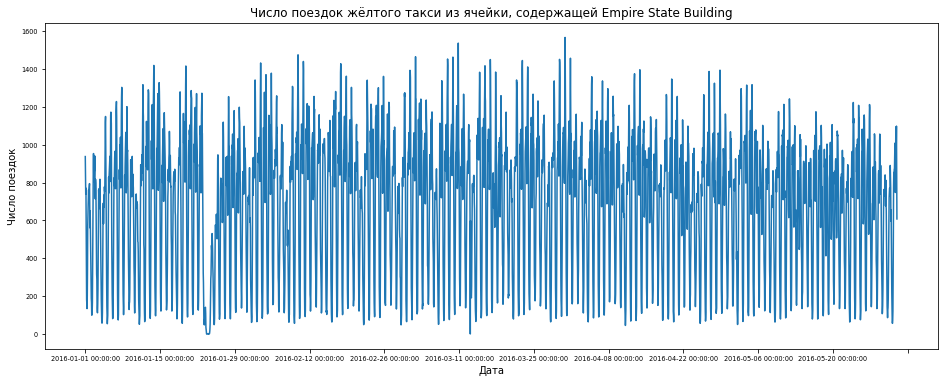

In [22]:
fig, ax = plt.subplots()

fig.set_figwidth(16)
fig.set_figheight(6)

ax.xaxis.set_major_locator(ticker.MultipleLocator(336)) # вывод дат каждые две недели
ax.tick_params(which='major', labelsize=6.5)

ax.plot(pred_region.index, pred_region['1231'], color='tab:blue')
plt.gca().set(title="Число поездок жёлтого такси из ячейки, содержащей Empire State Building", xlabel="Дата", ylabel="Число поездок")
plt.show()



Временной ряд имеет выраженную суточную сезонность, а так же некоторую аномалию во второй половине января. Посмотрим на STL декомпозицию ряда. Будем смотреть на двумесячный временной отрезок, чтобы не потерять информативности графика:

<Figure size 1152x504 with 0 Axes>

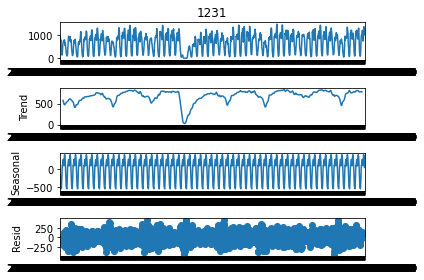

In [23]:
plt.figure(figsize=(16,7))
sm.tsa.seasonal_decompose(pred_region['1231'].iloc[:168*8], period=24).plot()
plt.show()

Видно, что в остатках присутствует структура. Так же присутствует недельная сезонность. Поэтому делаем вывод, что наш временной ряд нестационарен.

## 3
Далее будем строить регрессию для целевого признака (для того чтобы оценить параметры ARIMA). В первую очередь создадим регрессионые признаки для учета недельной сезонности. 

In [5]:
w = 168
t=np.arange(1, pred_region.shape[0]+1)
pred_region['constant'] = np.ones(pred_region.shape[0]) # константный признак необходим для несмещености прогноза

for i in range(1,51):
    sin = 's_'+str(i)
    cos = 'c_'+str(i)
    pred_region[sin]= np.sin(2*i*np.pi*t/w)
    pred_region[cos]= np.cos(2*i*np.pi*t/w)

In [25]:
model = sm.OLS(pred_region['1231'], pred_region.drop(['1231'], axis=1)).fit()

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   1231   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     311.7
Date:                Fri, 08 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:06:39   Log-Likelihood:                -22470.
No. Observations:                3648   AIC:                         4.514e+04
Df Residuals:                    3547   BIC:                         4.577e+04
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant     691.4640      1.923    359.561      0.000     687.694     695.234
s_1          -72.0795      2.721    -26.485      0.000     -77.415     -66.744
c_1           64.6131      2.718     23.774      0.000      59.284      69.942
s_2           39.0983      2.718     14.387      0.000      33.770      44.426
c_2           -7.5907      2.722     -2.789      0.005     -12.927      -2.254
s_3          -28.5407      2.721    -10.489      0.000     -33.876     -23.206
c_3           -1.0384      2.718     -0.382      0.702      -6.368       4.291
s_4           26.9743      2.718      9.924      0.000      21.645      32.304
c_4           18.5921      2.721      6.833      0.000      13.257      23.927
s_5           -7.6077      2.720     -2.797      0.005     -12.941      -2.274
c_5          -46.0078      2.719    -16.921      0.000     -51.339     -40.677
s_6          -49.8101      2.719    -18.320      0.000     -55.141     -44.479
c_6           49.6048      2.720     18.235      0.000      44.271      54.938
s_7         -367.5458      2.720   -135.145      0.000    -372.878    -362.214
c_7          -66.4573      2.720    -24.436      0.000     -71.790     -61.125
s_8           62.7779      2.720     23.084      0.000      57.446      68.110
c_8           -0.9005      2.720     -0.331      0.741      -6.233       4.432
s_9           12.7864      2.719      4.702      0.000       7.455      18.118
c_9          -23.3674      2.720     -8.591      0.000     -28.701     -18.034
s_10          -7.8875      2.720     -2.900      0.004     -13.220      -2.555
c_10          -3.8796      2.719     -1.427      0.154      -9.211       1.452
s_11          15.9253      2.719      5.857      0.000      10.594      21.256
c_11           1.6733      2.720      0.615      0.539      -3.660       7.007
s_12         -28.3244      2.720    -10.414      0.000     -33.657     -22.992
c_12         -19.8201      2.719     -7.288      0.000     -25.152     -14.488
s_13          10.2039      2.719      3.753      0.000       4.873      15.535
c_13         108.6438      2.720     39.940      0.000     103.311     113.977
s_14        -139.0981      2.720    -51.146      0.000    -144.430    -133.766
c_14         157.4014      2.720     57.876      0.000     152.069     162.734
s_15         -12.0222      2.719     -4.421      0.000     -17.354      -6.690
c_15         -29.4805      2.720    -10.839      0.000     -34.813     -24.148
s_16         -17.2344      2.719     -6.338      0.000     -22.566     -11.903
c_16           4.7347      2.720      1.741      0.082      -0.598      10.068
s_17           6.4263      2.720      2.363      0.018       1.094      11.759
c_17           5.0800      2.720      1.868      0.062      -0.252      10.412
s_18           0.5773      2.719      0.212      0.832      -4.754       5.909
c_

Как видно из summary с регрессией все в порядке, R-squared:	0.898 приемлемый. 

## 4
Посмотрим теперь на регрессионые остатки:

In [27]:
resid = pd.DataFrame(model.resid, columns={'resid'})

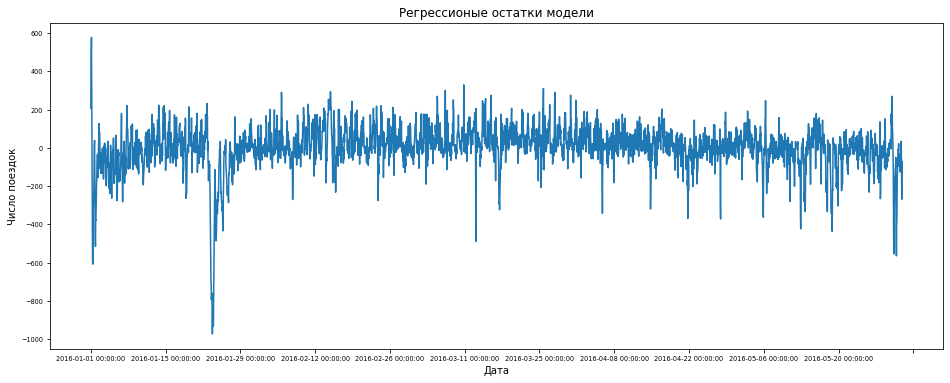

In [30]:
fig, ax = plt.subplots()

fig.set_figwidth(16)
fig.set_figheight(6)

ax.xaxis.set_major_locator(ticker.MultipleLocator(336)) # вывод дат каждые две недели
ax.tick_params(which='major', labelsize=6.5)

ax.plot(resid.index, resid, color='tab:blue')
plt.gca().set(title="Регрессионые остатки модели", xlabel="Дата", ylabel="Число поездок")
plt.show()


Остатки без выраженного тренда. Четко видны аномалии (одна во второй середине января, другая в середине марта). Посмотрим на STL-декомпозицию. 

<Figure size 720x504 with 0 Axes>

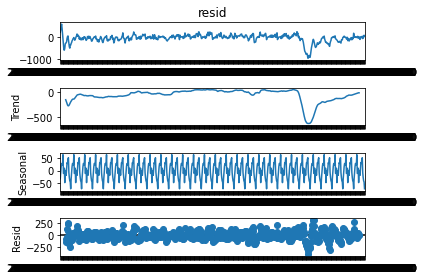

In [36]:
sm.tsa.seasonal_decompose(resid['resid'].iloc[:168*4], period=24).plot()
plt.show()

In [37]:
print('Критерий Дики-Фуллера с константой =', round(adfuller(resid['resid'])[1], 4))

Критерий Дики-Фуллера с константой = 0.0


Посмотрим теперь на остатки, продифференцированные по сезону:

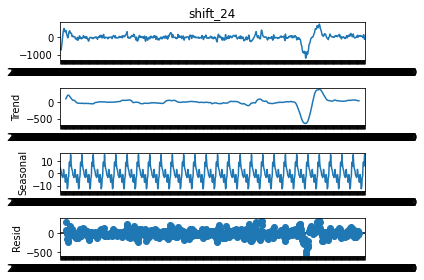

In [41]:
resid['shift_24'] = resid['resid']-resid['resid'].shift(24)
sm.tsa.seasonal_decompose(resid['shift_24'].iloc[25:168*4], period=24).plot()
plt.show()

В целом, сильно большого улучшения не наблюдается, поэтому для начального приближения можем остановится на этом и не смотреть на дифференцирование, поскольку оно значительно увеличит время на подбор параметров.

## 5
Рассмотрим графики автокорреляции и частичный автокорреляции:

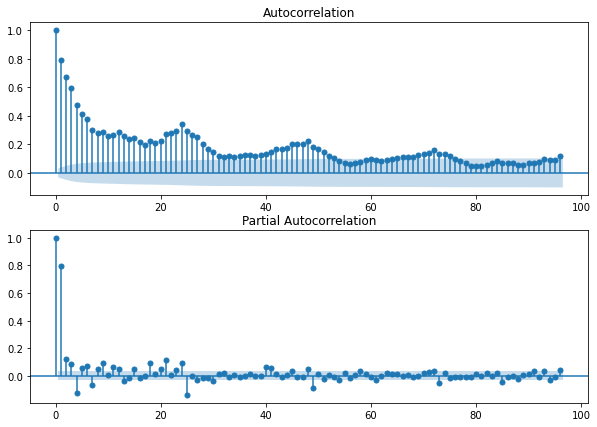

In [46]:
plt.figure(figsize=(10, 7)) 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid['resid'].values.squeeze(), lags=96, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid['resid'].values.squeeze(), lags=96, ax=ax)
plt.show()

По графику автокорреляции можем сделать вывод, что недельная сезонность присутствует в остатках, так же как и тренд. Тем не менее попробуем подобрать параметры, для того чтобы построить модель. Для экономии времени, начальные приближения выберем следующим образом: q=3, Q=2, p=1, P=1. Полный перебор параметров и их оценка осуществлялась в другом ноутбуке, и заняла порядка 9 часов. Сюда выпишем необходимую функцию для перебора и уже итоговый результат.

In [2]:
def sarimax_gridsearch(ts, exog, par, d=0, D=0, s=24, maxiter=30, freq='H'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by AIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best AIC value
    i = 0
    ans = []
    for comb in par:
        print('Step: ', i+1, 'par :', comb)
        try:
            
            model = sm.tsa.statespace.SARIMAX(ts, exog,
                                                order=(comb[0],d,comb[1]),
                                                seasonal_order=(comb[2],D, comb[3],s),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

            output = model.fit(maxiter=maxiter, method='nm', disp=-1)#, low_memory=True)
            print('Success')
            i+=1
            ans.append([comb,output.aic])
            
            print('SARIMAX {} x {}12 : AIC Calculated ={}'.format(comb, output.aic))
            
        except:
            print('Fail')
            i+=1
            continue

    # Find the parameters with minimal AIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pqPQ', 'aic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:10]
    
    return ans_df

## 6
Наилучший результат был получен для параметров q=3, Q=2, p=1, P=1, т.е. наше начальноое приближение по графикам автокорреляции. Есть вероятность, что параметры были оценены слишком грубо. Тем не менее будем анализировать данную модель:

In [6]:
p, q, P, Q, d, D = 1, 3, 1, 2, 0, 0
s=24
ex = pred_region.drop(['1231'], axis=1)

In [7]:
%%time
mod = sm.tsa.statespace.SARIMAX(pred_region['1231'],exog=ex, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)

Wall time: 34min 56s


In [8]:
print(mod.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                    1231   No. Observations:                 3648
Model:             SARIMAX(1, 0, 3)x(1, 0, [1, 2], 24)   Log Likelihood              -20049.834
Date:                                 Fri, 08 Apr 2022   AIC                          40317.667
Time:                                         17:56:57   BIC                          40992.113
Sample:                                     01-01-2016   HQIC                         40558.038
                                          - 05-31-2016                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant     691.5182     30.185     22.910      0.000     632.358     750

## 7
Построим наши данные с прогнозами модели:

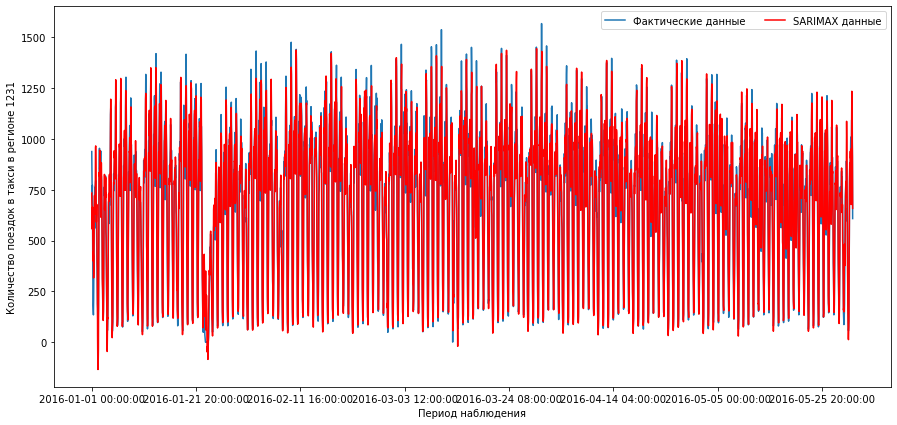

In [9]:
plt.figure(figsize=(15,7))
plot1 = pred_region['1231'].plot()
plot2 = mod.fittedvalues.plot(color='r')
plt.ylabel('Количество поездок в такси в регионе 1231')
plt.xlabel('Период наблюдения')
plt.legend( ['Фактические данные', 'SARIMAX данные'], loc=1, ncol = 2, prop={'size':10})
plt.show()
warnings.filterwarnings('default')

На вид результат довольно неплохой. Построим основные метрики, чтобы численно оценить результат. У модели первые $\max{\{(P+D)s+p+d, Qs+q}\}$ прогнозов не являются надежными (подробнее https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_sarimax_faq.html) и на них обращать внимания не стоит.

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 

def show_metrics(y_t, y_p):
    print('MSE: {:.2f}'.format(mean_squared_error(y_t, y_p)))
    print('mean_absolute_error: {:.2f}'.format(mean_absolute_error(y_t, y_p)))
    print('r2_score: {:.2f}'.format(r2_score(y_t, y_p)))

In [71]:
max_ex = max((𝑃+𝐷)*𝑠+𝑝+𝑑,𝑄*𝑠+𝑞)
show_metrics(pred_region['1231'][max_ex+1:].values, mod.fittedvalues[max_ex+1:].values)

MSE: 4072.71
mean_absolute_error: 46.34
r2_score: 0.97


## Прогноз

Попробуем построить прогноз на июнь 2016 года и сравнить с фактическими данными. Для начала создадим обобщенный датасет, с добавленным месяцем.

In [6]:
all_data =pd.concat([df,df_6], axis=0)
all_pred_region = all_data[['Unnamed: 0', '1231']].rename(columns={'Unnamed: 0': 'time'}).set_index('time')
all_pred_region.index = pd.to_datetime(all_pred_region.index)

Теперь построим регрессионные признаки аналогично тому, как мы строили для изначального датасета. 

In [7]:
w = 168
t=np.arange(1, all_pred_region.shape[0]+1)
all_pred_region['constant'] = np.ones(all_pred_region.shape[0]) # константный признак необходим для несмещености прогноза

for i in range(1,51):
    sin = 's_'+str(i)
    cos = 'c_'+str(i)
    all_pred_region[sin]= np.sin(2*i*np.pi*t/w)
    all_pred_region[cos]= np.cos(2*i*np.pi*t/w)

all_ex = all_pred_region.drop(['1231'], axis=1) # в отдельный датафрейм выделим экзогенные переменные

In [14]:
%%time
predict=mod.get_prediction(start=datetime.datetime.strptime("2016-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         end=datetime.datetime.strptime("2016-06-30 23:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         dynamic=False,  exog=all_ex[3648:])

Wall time: 284 ms


In [16]:
predict_conf_int = predict.conf_int() # доверительные интервалы для прогнозов
ci=predict_conf_int.loc['2016-01-01':,] 
pred_means = predict.predicted_mean # за прогноз возьмем среднее по предсказанием 

Построим на графике фактические данные, прогноз на июнь 2016 года и доверительные интервалы:

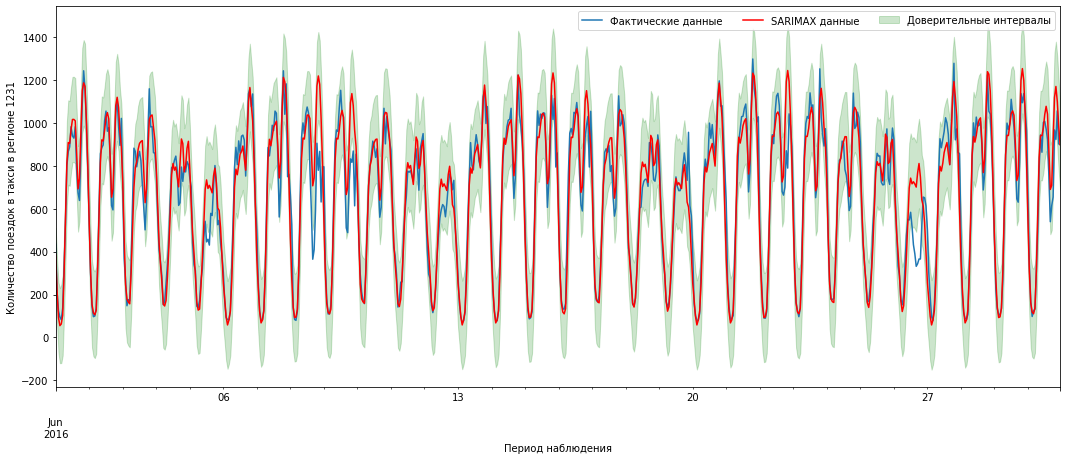

In [18]:
plt.figure(figsize=(18,7))

plot1 = all_pred_region['1231'][3648:].plot()
plot2 = pred_means[3648:].plot(color='r')
plot3 = plt.fill_between(ci.iloc[3648:,0].index, ci.iloc[3648:,0].values, ci.iloc[3648:,1].values, color='g', alpha=0.2)


plt.ylabel('Количество поездок в такси в регионе 1231')
plt.xlabel('Период наблюдения')
plt.legend( ['Фактические данные', 'SARIMAX данные', 'Доверительные интервалы'], loc=1, ncol = 3, prop={'size':10})

plt.show()


Метрики на тестовом датасете (за июнь):

In [407]:
show_metrics(all_pred_region['1231'][3648:].values, pred_means[3648:].values)

MSE: 9630.87
mean_absolute_error: 65.18
r2_score: 0.91


## 8
### Итоги первой модели SARIMAX

В данных видна четкая недельная сезонность (а именно, в воскресенье происходит меньше поездок), на которых наш прогноз более оптимистичный. Таким образом следует добавить регрессионые признаки на определение выходных дней. Также можно заметить, что больше вызовов такси в вечернее время (основные пики приходятся как раз на них). Таким образом, несмотря на то, что модель имеет неплохую прогнозную силу, ее можно попытаться улучшить добавив несколько регрессионых признаков. 

In [23]:
df_6=pd.read_csv("data/aggs/taxi_2016_06.csv")
df_5=pd.read_csv("data/aggs/taxi_2016_05.csv")
df_3=pd.read_csv("data/aggs/taxi_2016_03.csv")
df_4=pd.read_csv("data/aggs/taxi_2016_04.csv")
df_2=pd.read_csv("data/aggs/taxi_2016_02.csv")
df_1=pd.read_csv("data/aggs/taxi_2016_01.csv")
df=pd.concat([ df_1,df_2,df_3,df_4,df_5], axis=0)
new_pred_region = df[['Unnamed: 0', '1231']].rename(columns={'Unnamed: 0': 'time'}).set_index('time')
new_pred_region.index = pd.to_datetime(new_pred_region.index)
new_pred_region['constant'] = np.ones(new_pred_region.shape[0])

In [24]:
new_pred_region['is_weekends'] = np.array((new_pred_region.index.weekday==6)|(new_pred_region.index.weekday==5)) # создадим индикатор выходных

hol_list = ['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30'] # массив с национальными праздниками
x = np.array([True if str(i).split()[0] in hol_list else False for i in new_pred_region.index]) 

new_pred_region['is_weekends'] = np.array(new_pred_region['is_weekends']) + x # добавим к индикаторам выходных индикаторы праздников
new_pred_region['is_weekends'] = new_pred_region['is_weekends'].astype(int)

new_pred_region['is_evening'] = np.array((new_pred_region.index.hour == 19)|(new_pred_region.index.hour == 20), dtype=int) # индикатор вечера 
new_pred_region['is_anomaly'] = np.array((new_pred_region.index.month == 1)&(new_pred_region.index.day == 23), dtype=int) # индикактор аномалии (23 января 2016 была снежная буря в Нью-Йорке)

In [25]:
new_pred_region['trend_comp'] = np.arange(1, new_pred_region.shape[0]+1)**2/(new_pred_region.shape[0]+1) # компонента времени 

w = 168
t=np.arange(1, new_pred_region.shape[0]+1)
 # константный признак необходим для несмещености прогноза

for i in range(1,61):
    sin = 's_'+str(i)
    cos = 'c_'+str(i)
    new_pred_region[sin]= np.sin(2*i*np.pi*t/w)
    new_pred_region[cos]= np.cos(2*i*np.pi*t/w)

In [376]:
new_model = sm.OLS(new_pred_region['1231'], new_pred_region.drop(['1231'], axis=1)).fit()

In [ ]:
new_model.summary()

In [378]:
new_resid = pd.DataFrame(new_model.resid, columns={'resid'})

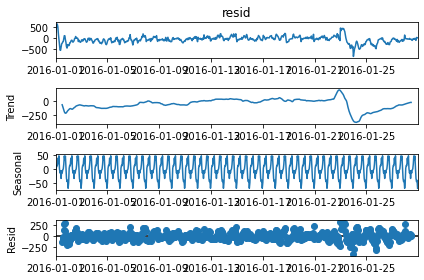

In [380]:
sm.tsa.seasonal_decompose(new_resid['resid'].iloc[:168*4], period=24).plot()
plt.show()

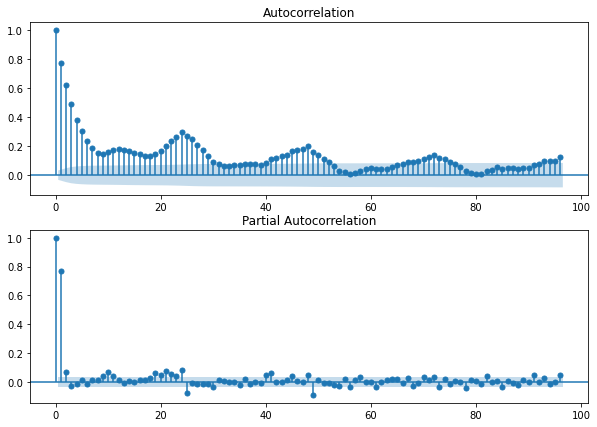

In [381]:
plt.figure(figsize=(10, 7)) 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(new_resid['resid'].values.squeeze(), lags=96, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(new_resid['resid'].values.squeeze(), lags=96, ax=ax)
plt.show()

In [7]:
new_ex = new_pred_region.drop(['1231'], axis=1)

При переборе параметров с аналогичным начальным приближением, оптимальными параметрами оказались те же самые, что и для прошлой модели (что вероятно опять свидетельствует плохому начальному приближению). Более того, при обучении модели на тех же параметрах, но с расширенными регрессиоными признаками, значение метрик на тренировочном датасете улучшились, а на тестовом ухудшились (конкретные значения будут представлены ниже), что свидетельствует о переобучении. Попробуем обучит модель с другими параметрами, которые более соответствуют графикам автокорреляций, но явно увеличат время обучения.  

In [10]:
p, q, P, Q, d, D = 1, 5, 1, 3, 0, 0
s=24

In [11]:
%%time
mod = sm.tsa.statespace.SARIMAX(new_pred_region['1231'],exog=new_ex, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,freq='H').fit(disp=False)

Wall time: 3h 3min 26s


In [13]:
print(mod.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                       1231   No. Observations:                 3648
Model:             SARIMAX(1, 0, 5)x(1, 0, [1, 2, 3], 24)   Log Likelihood              -19798.046
Date:                                    Sat, 09 Apr 2022   AIC                          39868.093
Time:                                            13:16:42   BIC                          40708.616
Sample:                                        01-01-2016   HQIC                         40167.764
                                             - 05-31-2016                                         
Covariance Type:                                      opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
constant      733.8704     21.103     34.775    

In [16]:
max_ex_new = max((𝑃+𝐷)*𝑠+𝑝+𝑑,𝑄*𝑠+𝑞)

In [17]:
show_metrics(new_pred_region['1231'][max_ex_new+1:].values, mod.fittedvalues[max_ex_new+1:].values)

MSE: 3832.62
mean_absolute_error: 44.25
r2_score: 0.97


In [392]:
# значение метрик на тренировочном датасете с параметрами p, q, P, Q, d, D = 1, 3, 1, 2, 0, 0 (как у модели без дополнительных регрессионых признаков)
# не запускать ячейку, так как переменные уже перезаписаны
show_metrics(new_pred_region['1231'][max_ex+1:].values, mod.fittedvalues[max_ex+1:].values)

MSE: 3833.52
mean_absolute_error: 44.26
r2_score: 0.97


## Прогноз полного нового датасета:

In [28]:
new_all_data =pd.concat([df,df_6], axis=0)
new_all_pred_region = new_all_data[['Unnamed: 0', '1231']].rename(columns={'Unnamed: 0': 'time'}).set_index('time')
new_all_pred_region.index = pd.to_datetime(new_all_pred_region.index)

new_all_pred_region['constant'] = np.ones(new_all_pred_region.shape[0])
new_all_pred_region['is_weekends'] = np.array((new_all_pred_region.index.weekday==6)|(new_all_pred_region.index.weekday==5)) # создадим индикатор выходных

hol_list = ['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30'] # массив с национальными праздниками
x = np.array([True if str(i).split()[0] in hol_list else False for i in new_all_pred_region.index]) 

new_all_pred_region['is_weekends'] = np.array(new_all_pred_region['is_weekends']) + x # добавим к индикаторам выходных индикаторы праздников
new_all_pred_region['is_weekends'] = new_all_pred_region['is_weekends'].astype(int)

new_all_pred_region['is_evening'] = np.array((new_all_pred_region.index.hour == 19)|(new_all_pred_region.index.hour == 20), dtype=int) # индикатор вечера
new_all_pred_region['is_anomaly'] = np.array((new_all_pred_region.index.month == 1)&(new_all_pred_region.index.day == 23), dtype=int) # индикактор аномалии (23 января 2016 была снежная буря в Нью-Йорке)
new_all_pred_region['trend_comp'] = np.arange(1, new_all_pred_region.shape[0]+1)**2/(new_all_pred_region.shape[0]+1) # компонента времени 

w = 168
t=np.arange(1, new_all_pred_region.shape[0]+1)
 # константный признак необходим для несмещености прогноза

for i in range(1,61):
    sin = 's_'+str(i)
    cos = 'c_'+str(i)
    new_all_pred_region[sin]= np.sin(2*i*np.pi*t/w)
    new_all_pred_region[cos]= np.cos(2*i*np.pi*t/w)
    
new_all_ex = new_all_pred_region.drop(['1231'], axis=1)

In [19]:
%%time
new_predict=mod.get_prediction(start=datetime.datetime.strptime("2016-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         end=datetime.datetime.strptime("2016-06-30 23:00:00", "%Y-%m-%d %H:%M:%S"), 
                                         dynamic=False,  exog=new_all_ex[3648:])

Wall time: 1.63 s


In [21]:
predict_conf_int_new = new_predict.conf_int() # доверительные интервалы для прогнозов
ci_new=predict_conf_int_new.loc['2016-01-01':,] 
pred_means_new = new_predict.predicted_mean # за прогноз возьмем среднее по предсказанием 

### Прогноз обновленной модели SARIMAX

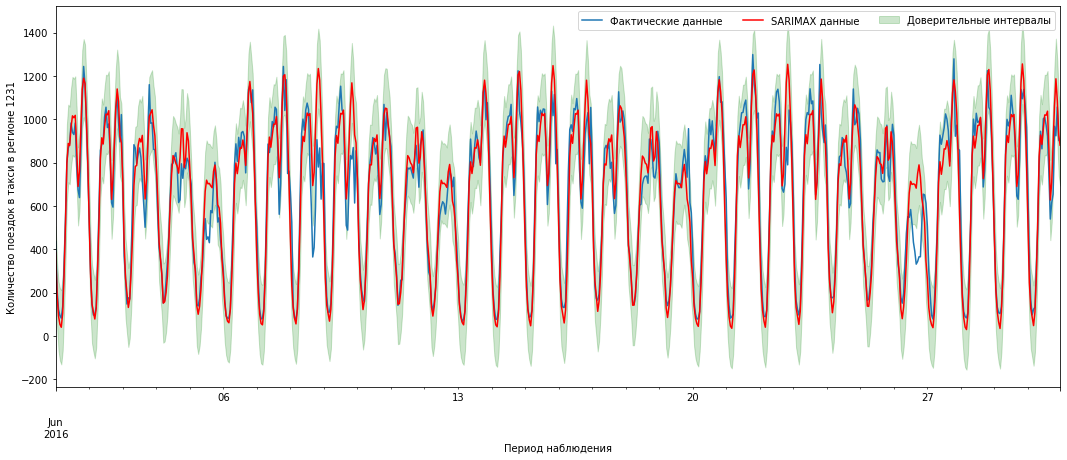

In [22]:
plt.figure(figsize=(18,7))

plot1 = new_all_pred_region['1231'][3648:].plot()
plot2 = pred_means_new[3648:].plot(color='r')
plot3 = plt.fill_between(ci_new.iloc[3648:,0].index, ci_new.iloc[3648:,0].values, ci_new.iloc[3648:,1].values, color='g', alpha=0.2)


plt.ylabel('Количество поездок в такси в регионе 1231')
plt.xlabel('Период наблюдения')
plt.legend( ['Фактические данные', 'SARIMAX данные', 'Доверительные интервалы'], loc=1, ncol = 3, prop={'size':10})

plt.show()


In [23]:
show_metrics(new_all_pred_region['1231'][3648:].values, pred_means_new[3648:].values)

MSE: 10224.54
mean_absolute_error: 70.45
r2_score: 0.90


In [410]:
# значение метрик на тестовом датасете с параметрами p, q, P, Q, d, D = 1, 3, 1, 2, 0, 0 (как у модели без дополнительных регрессионых признаков)
# не запускать ячейку, так как переменные уже перезаписаны
show_metrics(new_all_pred_region['1231'][3648:].values, pred_means_new[3648:].values)

MSE: 10234.78
mean_absolute_error: 70.53
r2_score: 0.90


### Бонус
Перед основным выводом, бонусом обучим простые линейные регрессии и посмотрим на их значения на тех же признаках:

In [44]:
mod_OLS = sm.OLS(all_pred_region['1231'][:3648], all_ex[:3648]).fit()

In [50]:
show_metrics(all_pred_region['1231'][:3648], mod_OLS.fittedvalues.values)

MSE: 13111.85
mean_absolute_error: 73.09
r2_score: 0.90


In [46]:
show_metrics(all_pred_region['1231'][3648:], mod_OLS.predict(all_ex[3648:]))

MSE: 12064.98
mean_absolute_error: 72.79
r2_score: 0.88


Теперь обучим регрессию на датасете с дополнительными регрессиоными признаками:

In [41]:
mod_OLS_reg = sm.OLS(new_all_pred_region['1231'][:3648], new_all_ex[:3648]).fit()

In [42]:
show_metrics(new_all_pred_region['1231'][:3648], mod_OLS_reg.fittedvalues.values)

MSE: 10540.81
mean_absolute_error: 69.51
r2_score: 0.92


In [43]:
show_metrics(new_all_pred_region['1231'][3648:], mod_OLS_reg.predict(new_all_ex[3648:]))

MSE: 10891.41
mean_absolute_error: 72.97
r2_score: 0.89


## Вывод

Модели SARIMAX (p, q, P, Q) и SARIMAX_reg (p, q, P, Q) (с дополнительными регрессиоными признаками): 

metric(train/test)|SARIMAX (1, 3, 1, 2)|SARIMAX_reg (1, 3, 1, 2)| SARIMAX_reg (1, 5, 1, 3)| OLS | OLS_reg 
---|---|---|---|---|---
MSE| 4072.71/9630.87 | 3833.52/10234.78 | 3832.62/10224.54 | 13111.85/12064.98 | 10540.81/10891.41 |
MAE| 46.34/65.18 | 44.26/70.53 | 44.25/70.45 | 73.09/72.79| 69.51/72.97 |
r2| 0.97/0.9 | 0.97/0.9 | 0.97/0.9 | 0.9/0.88 | 0.92/0.89 |

Как видно из таблицы выше новые регрессионые признаки по всей видимости переобучили модели (причем как SARIMAX, так и регрессии). Вероятнее всего признаки подобраны неудачно. Времязатратность подбора параметров (для первой модели подбор параметров занял ~9 часов, обучение ~40 минут, для второй ~10 часов и обучение с другими параметрами ~3 часа) не дает возможности быстрого перебора признаков. Поэтому в данной ситуации лучше воспользоваться обычной регрессией для нахождения оптимальных признаков, а затем уже пробовать SARIMAX. 

По всей видимости, для улучшения самой модели SARIMAX, нужно все же добавлять сезонное дифференцирование и увеличивать число параметров для перебора.